# E-06. Kaggle ML month with KaKR(2019 2nd)

---


## 데이터 가져오기

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

In [77]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [78]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [79]:
train.shape, test.shape

((15035, 21), (6468, 20))


---

## 데이터 확인하기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [80]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 타겟 데이터 확인
타겟 데이터인 `price`에 대해 확인해보자

<AxesSubplot:>

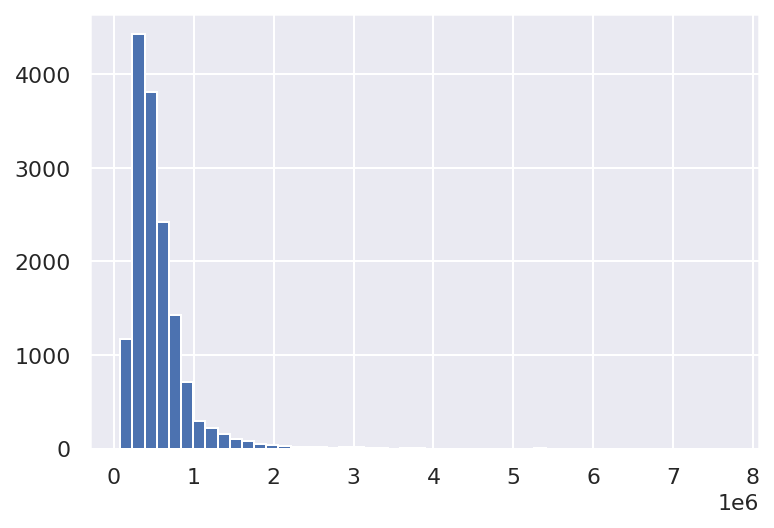

In [81]:
# 기초 통계량
train['price'].hist(bins=50)

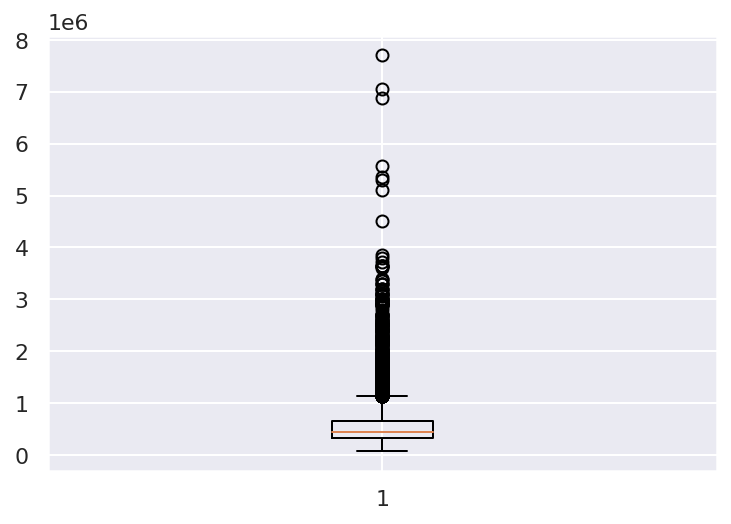

In [82]:
# boxplot - matplotlib
plt.boxplot(train['price'])
plt.show()

### 데이터의 비대칭 정도를 확인 (Skewness)
- Skewness(비대칭도): 분포가 얼마나 비대칭을 띄는가 알려주는 척도

(비대칭도: a=0이면 정규분포, a<0 이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침)

In [83]:
for col in train:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(train[col].kurt())  
         )

id              Skewness: 00.00     Kurtosis: -01.20
date            Skewness: 00.77     Kurtosis: -01.40
price           Skewness: 04.29     Kurtosis: 040.15
bedrooms        Skewness: 00.52     Kurtosis: 001.66
bathrooms       Skewness: 00.51     Kurtosis: 001.34
sqft_living     Skewness: 01.49     Kurtosis: 005.73
sqft_lot        Skewness: 13.35     Kurtosis: 297.94
floors          Skewness: 00.59     Kurtosis: -00.53
waterfront      Skewness: 11.73     Kurtosis: 135.57
view            Skewness: 03.38     Kurtosis: 010.76
condition       Skewness: 01.04     Kurtosis: 000.56
grade           Skewness: 00.75     Kurtosis: 001.18
sqft_above      Skewness: 01.43     Kurtosis: 003.38
sqft_basement   Skewness: 01.56     Kurtosis: 002.35
yr_built        Skewness: -0.47     Kurtosis: -00.67
yr_renovated    Skewness: 04.57     Kurtosis: 018.88
zipcode         Skewness: 00.41     Kurtosis: -00.85
lat             Skewness: -0.49     Kurtosis: -00.67
long            Skewness: 00.92     Kurtosis: 

- `waterfront`, `sqft_lot`, `sqft_lot15`가 좌측으로 치우쳐져 있는 것을 볼 수 있다.

----

### 변수간 상관관계를 확인하기 

- Heatmap을 활용하여 변수간 상관관계 확인

In [84]:
# heatmap (seaborn)

cols = ['price', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long' , 'sqft_living15', 'sqft_lot15']

corr = train[cols].corr(method = 'pearson')
corr

,price,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.007717,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
date,0.007717,1.000000,-0.002696,-0.022810,-0.022119,0.007500,-0.020891,-0.001742,0.013986,-0.047028,-0.023233,-0.019422,-0.009627,0.004517,-0.019625,-0.000763,-0.031683,0.002894,-0.014327,0.003511
bedrooms,0.323672,-0.002696,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.525479,-0.022810,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.702899,-0.022119,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,0.096793,0.007500,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.262588,-0.020891,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,0.265738,-0.001742,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,0.400806,0.013986,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,0.039740,-0.047028,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


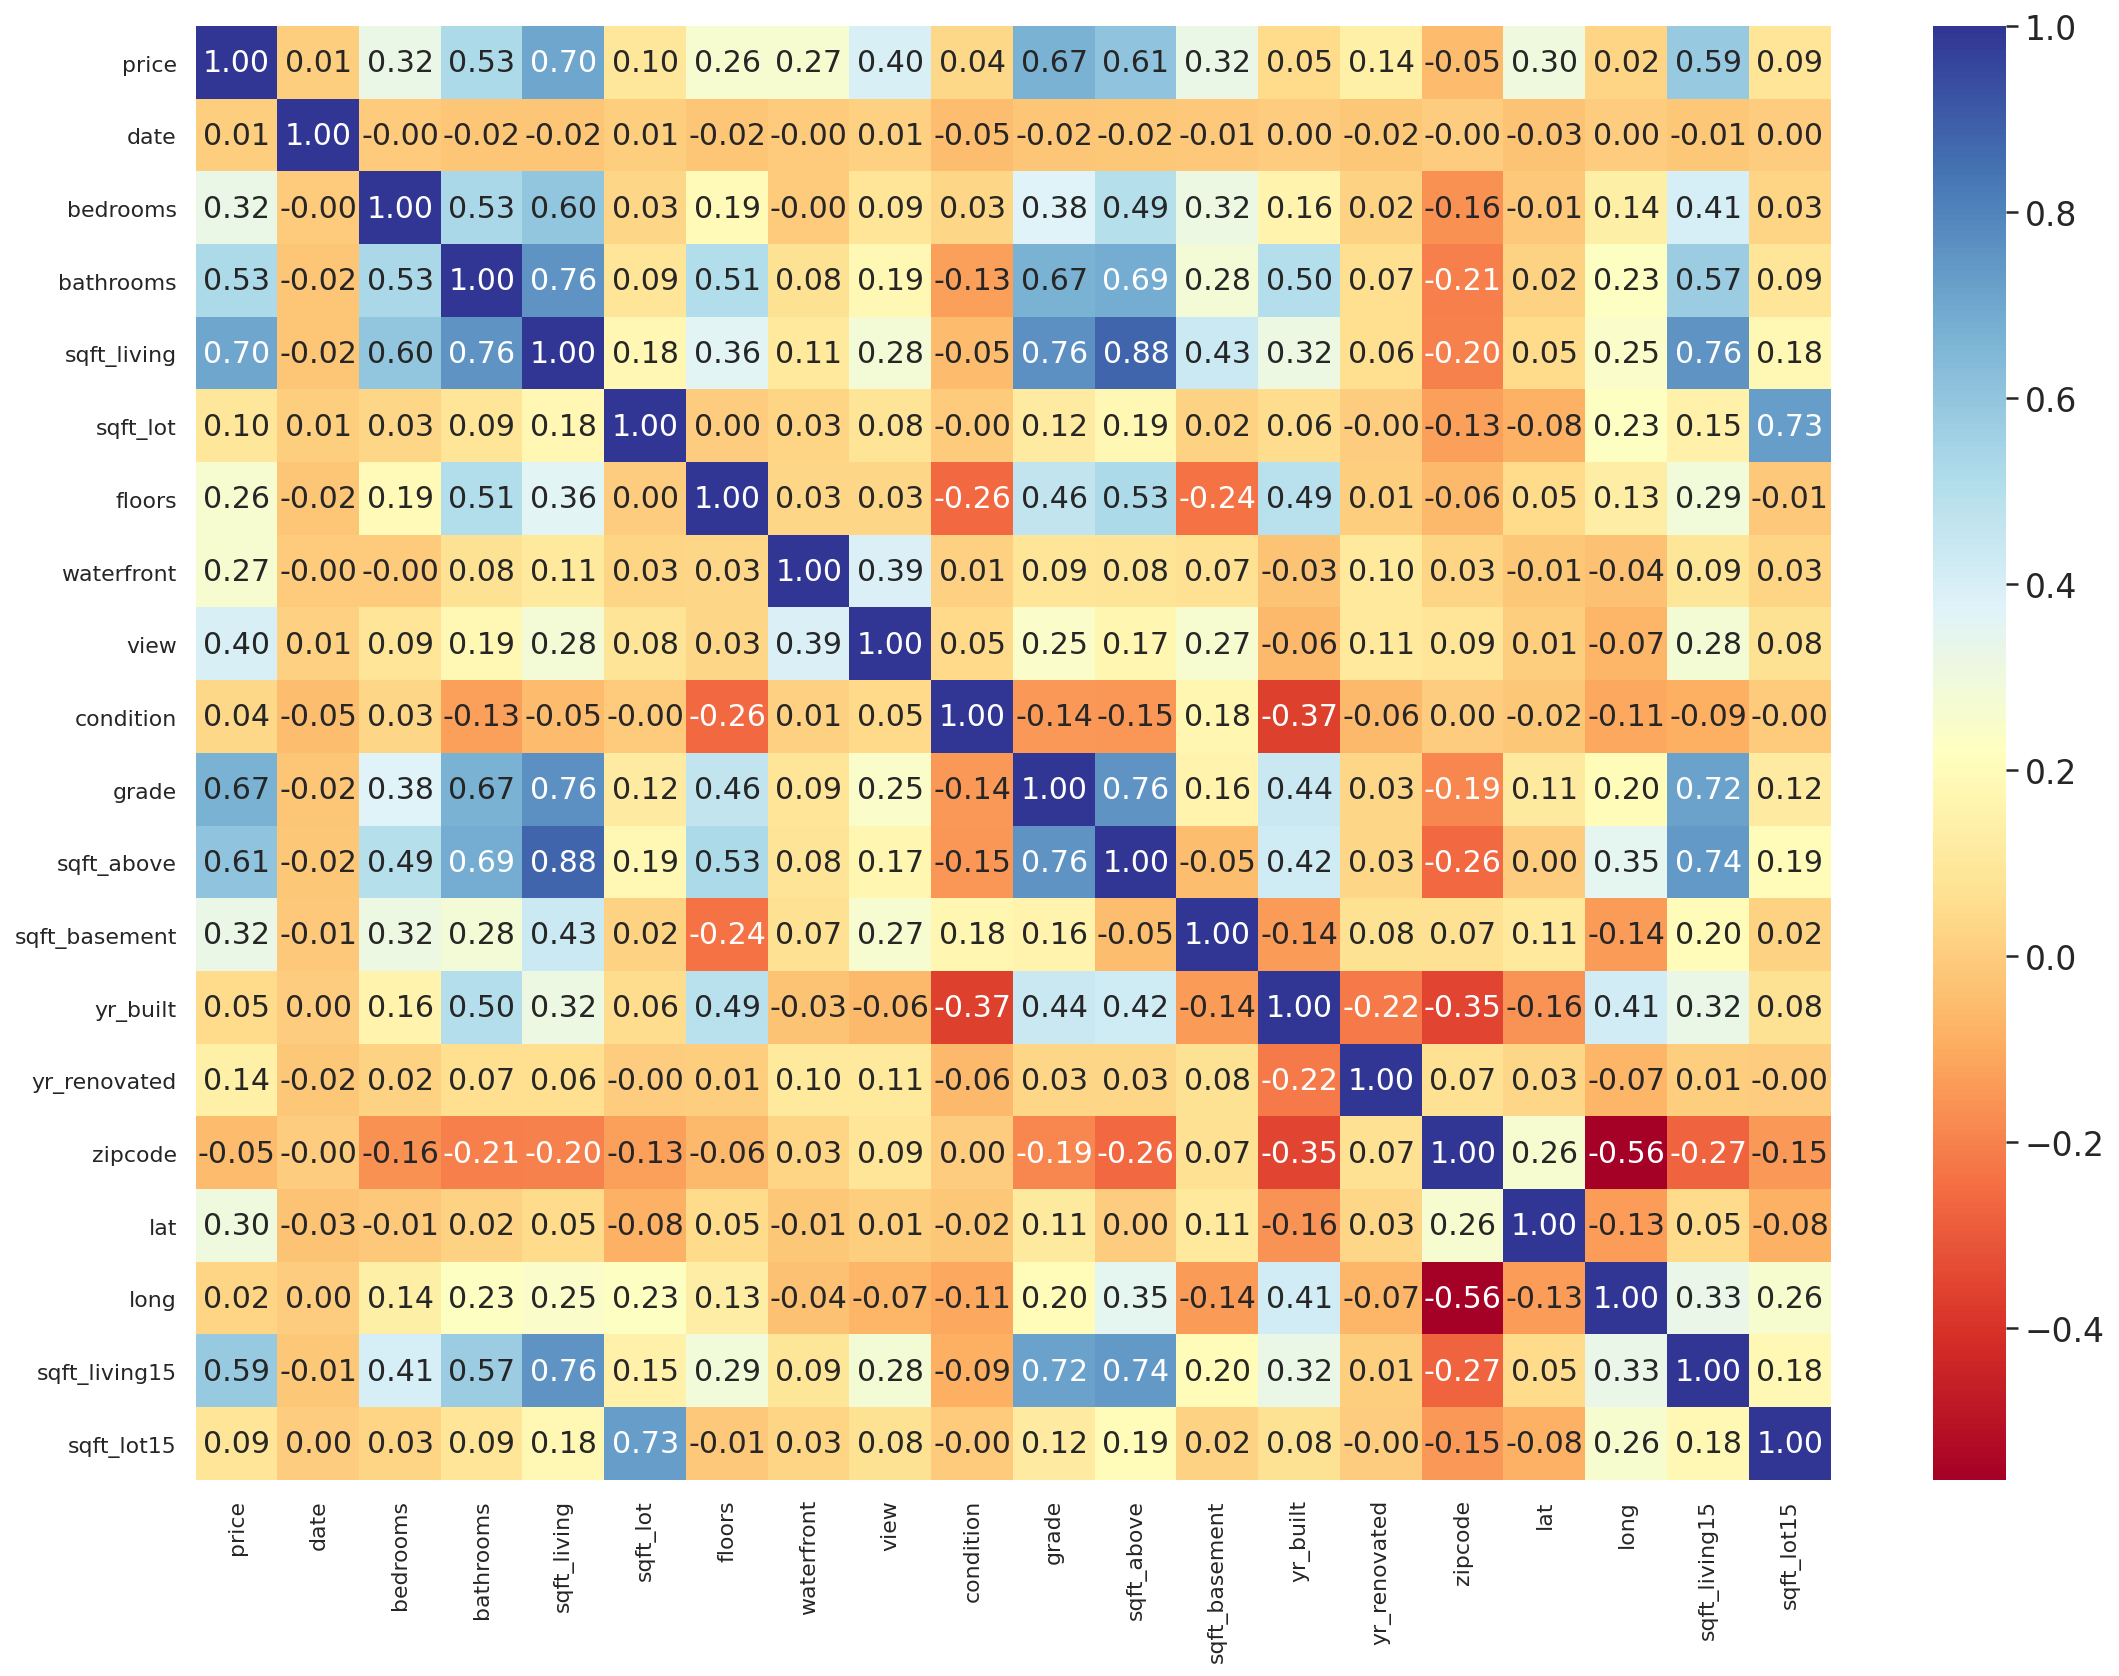

In [51]:
fig = plt.figure(figsize = (16, 12))
ax = fig.gca()

sns.set(font_scale = 1.5)  # heatmap 안의 font-size 설정
heatmap = sns.heatmap(corr.values, annot = True, fmt='.2f', annot_kws={'size':15},
                      yticklabels = cols, xticklabels = cols, ax=ax, cmap = "RdYlBu")
plt.tight_layout()
plt.show()

- 밀접한 관련이 있어보이는 데이터들
     - 'bedrooms', 'sqft_living'
     - 'bathrooms', 'sqft_living' 
     - 'bathrooms', 'sqft_above' 
     - 'sqft_living', 'sqft_above'
     - 'sqft_living', 'sqft_living15'
     -  'sqft_lot', 'sqft_lot15' 
     - 'grade', 'bathrooms' 
     - 'grade', 'sqft_living'
     - 'grade', 'sqft_above'
     - 'grade', 'sqft_living15
     - 'sqft_living15', 'sqft_above' 

→ 다중공선성 문제를 생각하여 'sqft_living15', 'bathrooms', 'sqft_lot15', 'bedrooms'에 대한 전처리가 필요하지 않을까 생각된다.

- target feature와 관련 있어 보이는 데이터
    - 'sqft_living', 'grade', 'sqft_above', 'sqft_living15' 
    - `price`와 상관관계가 강하다고 생각되는 데이터를 좀 더자세히 확인해보자

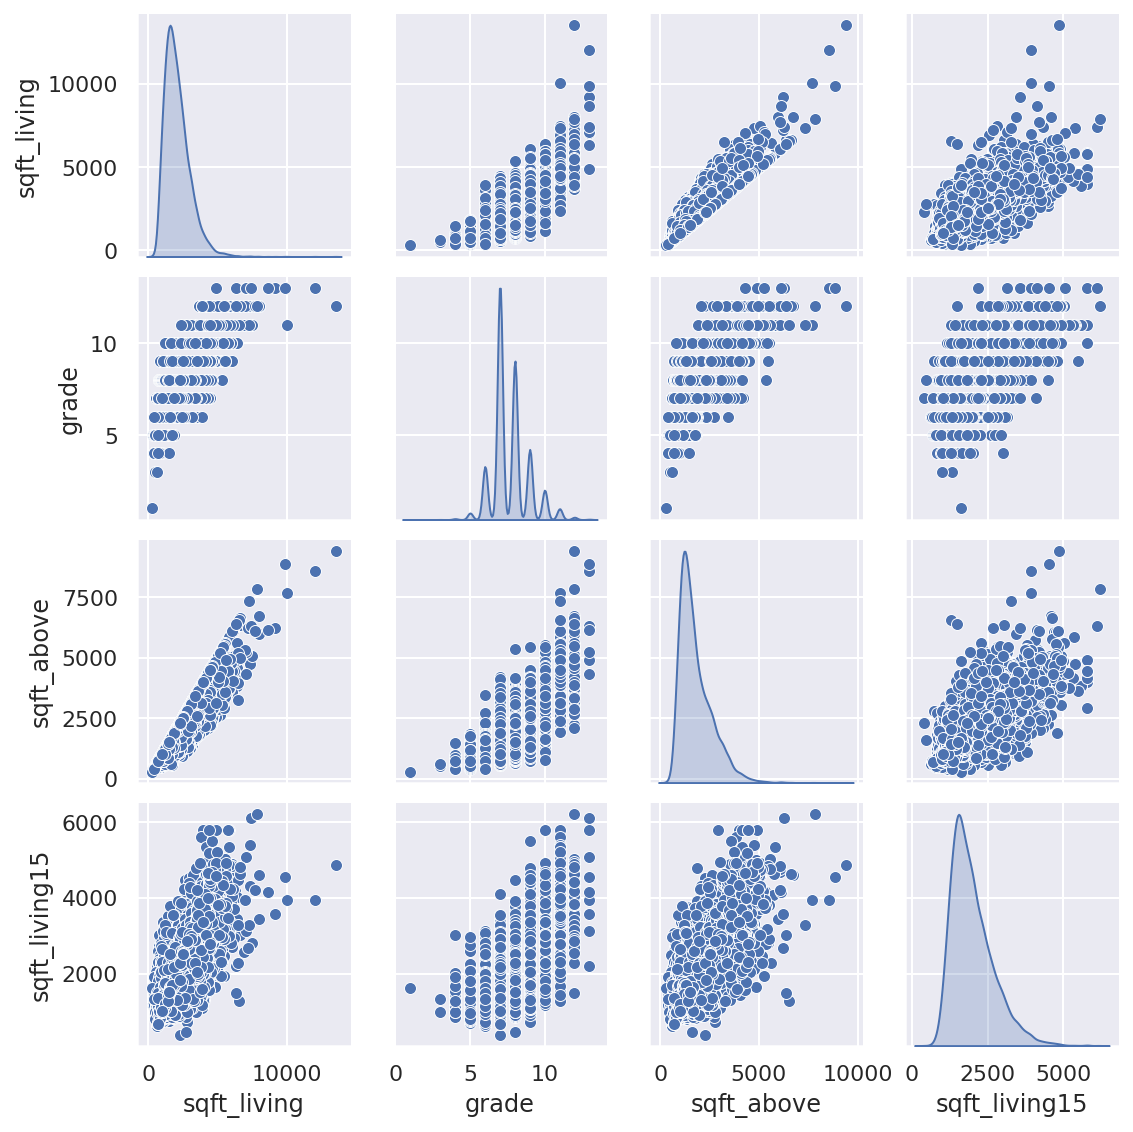

In [85]:
sns.set() 
columns = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15'] 
sns.pairplot(train[columns],size = 2 ,kind ='scatter',diag_kind='kde') 
plt.show()


---

## 3. 데이터 전처리하기

- 타겟 값이 될 `price`를 분리하기


In [86]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [87]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

21503


In [88]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 결측치 확인하기

<AxesSubplot:>

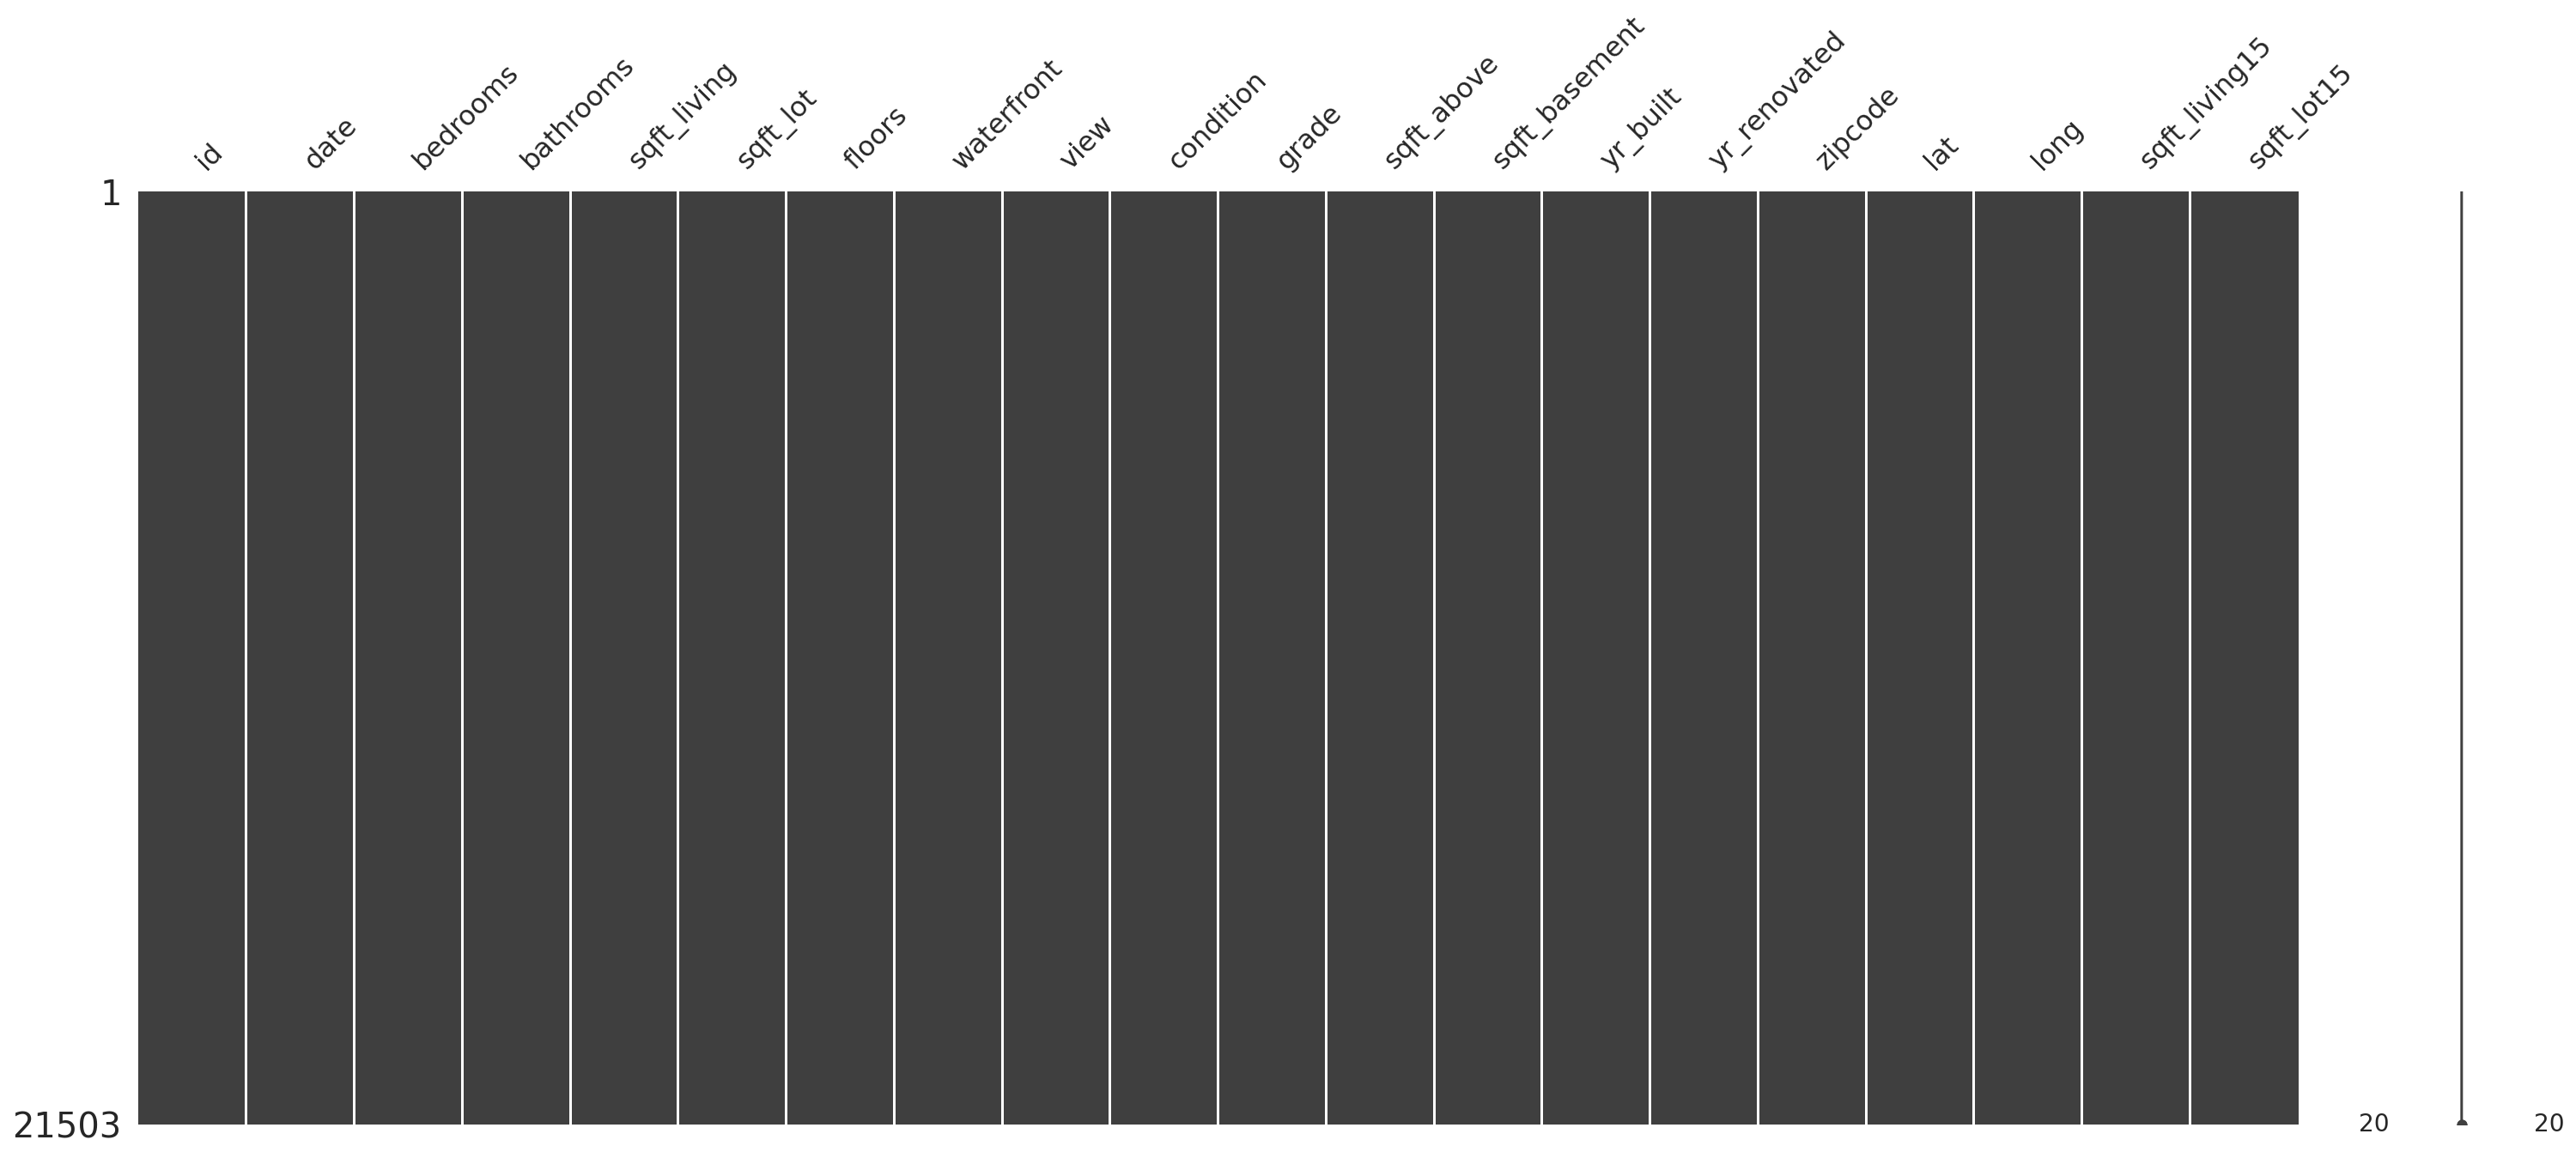

In [89]:
msno.matrix(data)

In [90]:
# 결측치 확인
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [91]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [92]:
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [93]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int64  
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

- `id`컬럼은 잠시 다른 변수에 담아두고 본 데이터에서는 삭제

In [95]:
sub_id = data['id'][train_len:]

del data['id']


- 정규화를 위해 데이터들의 현재 분포를 그래프로 확인한다. 

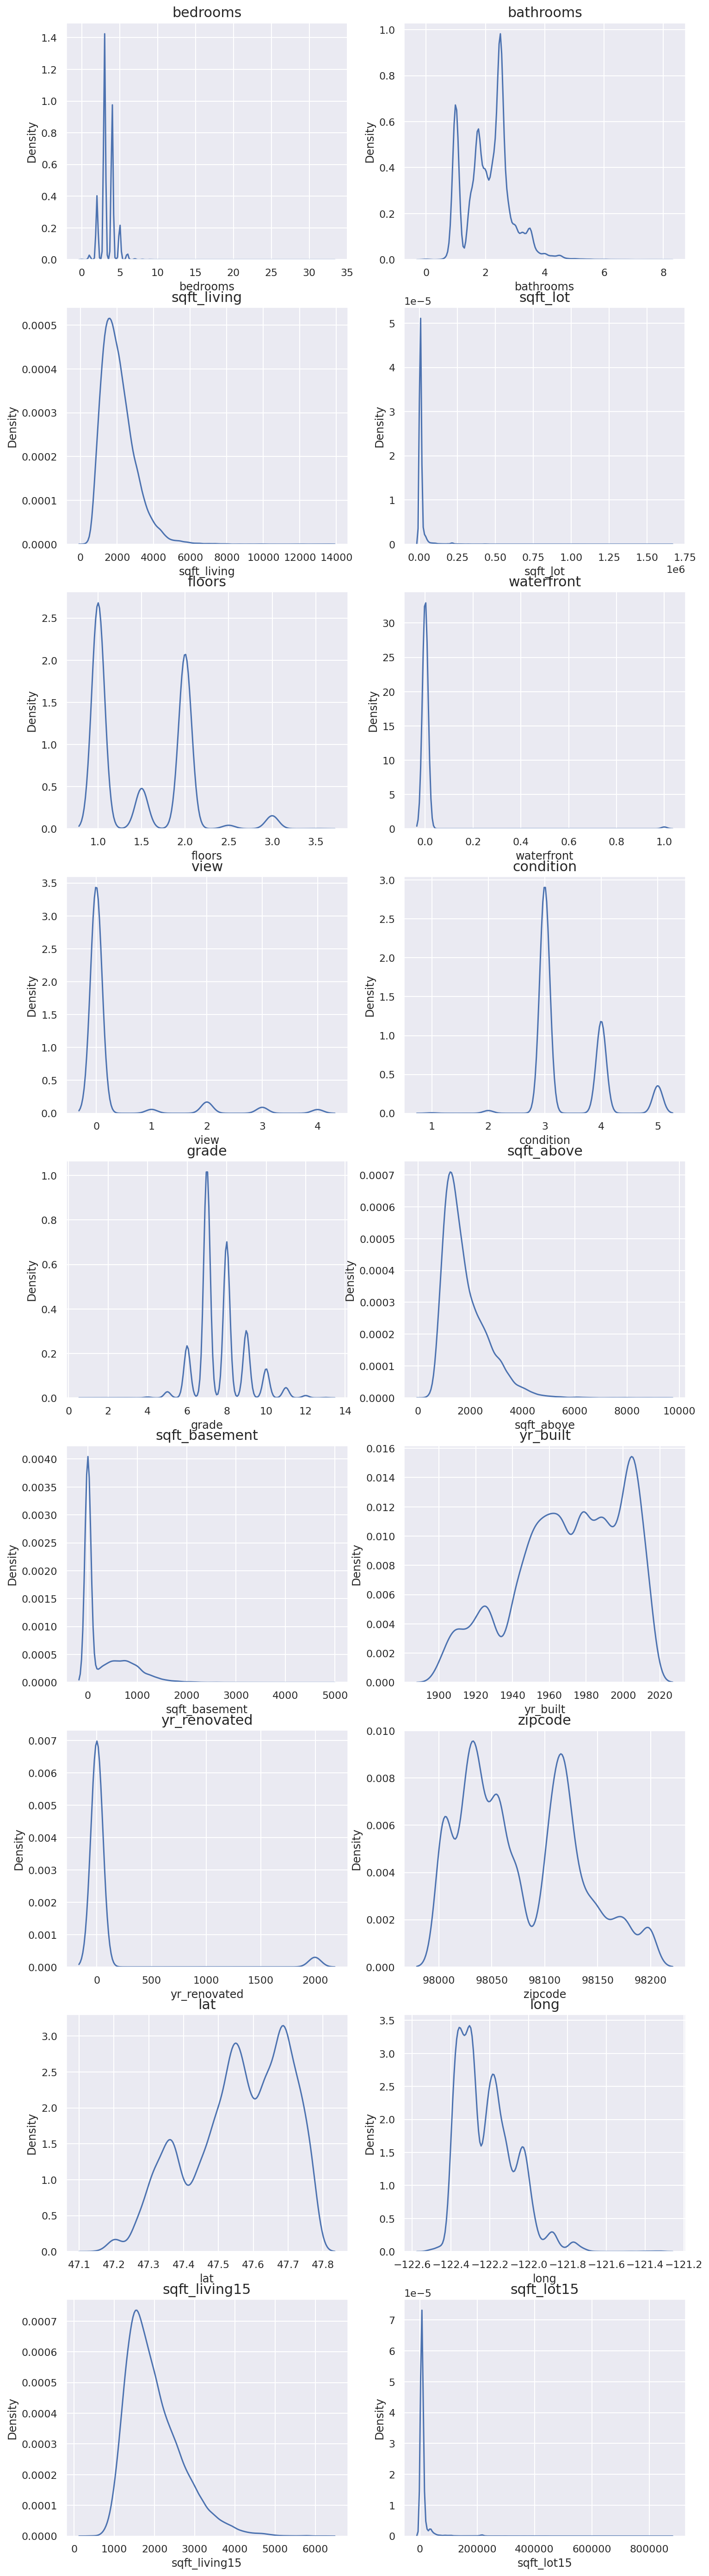

In [96]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

- 한쪽으로 치우쳐져 있는 변수들에 대해 로그 변환을 진행

In [97]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

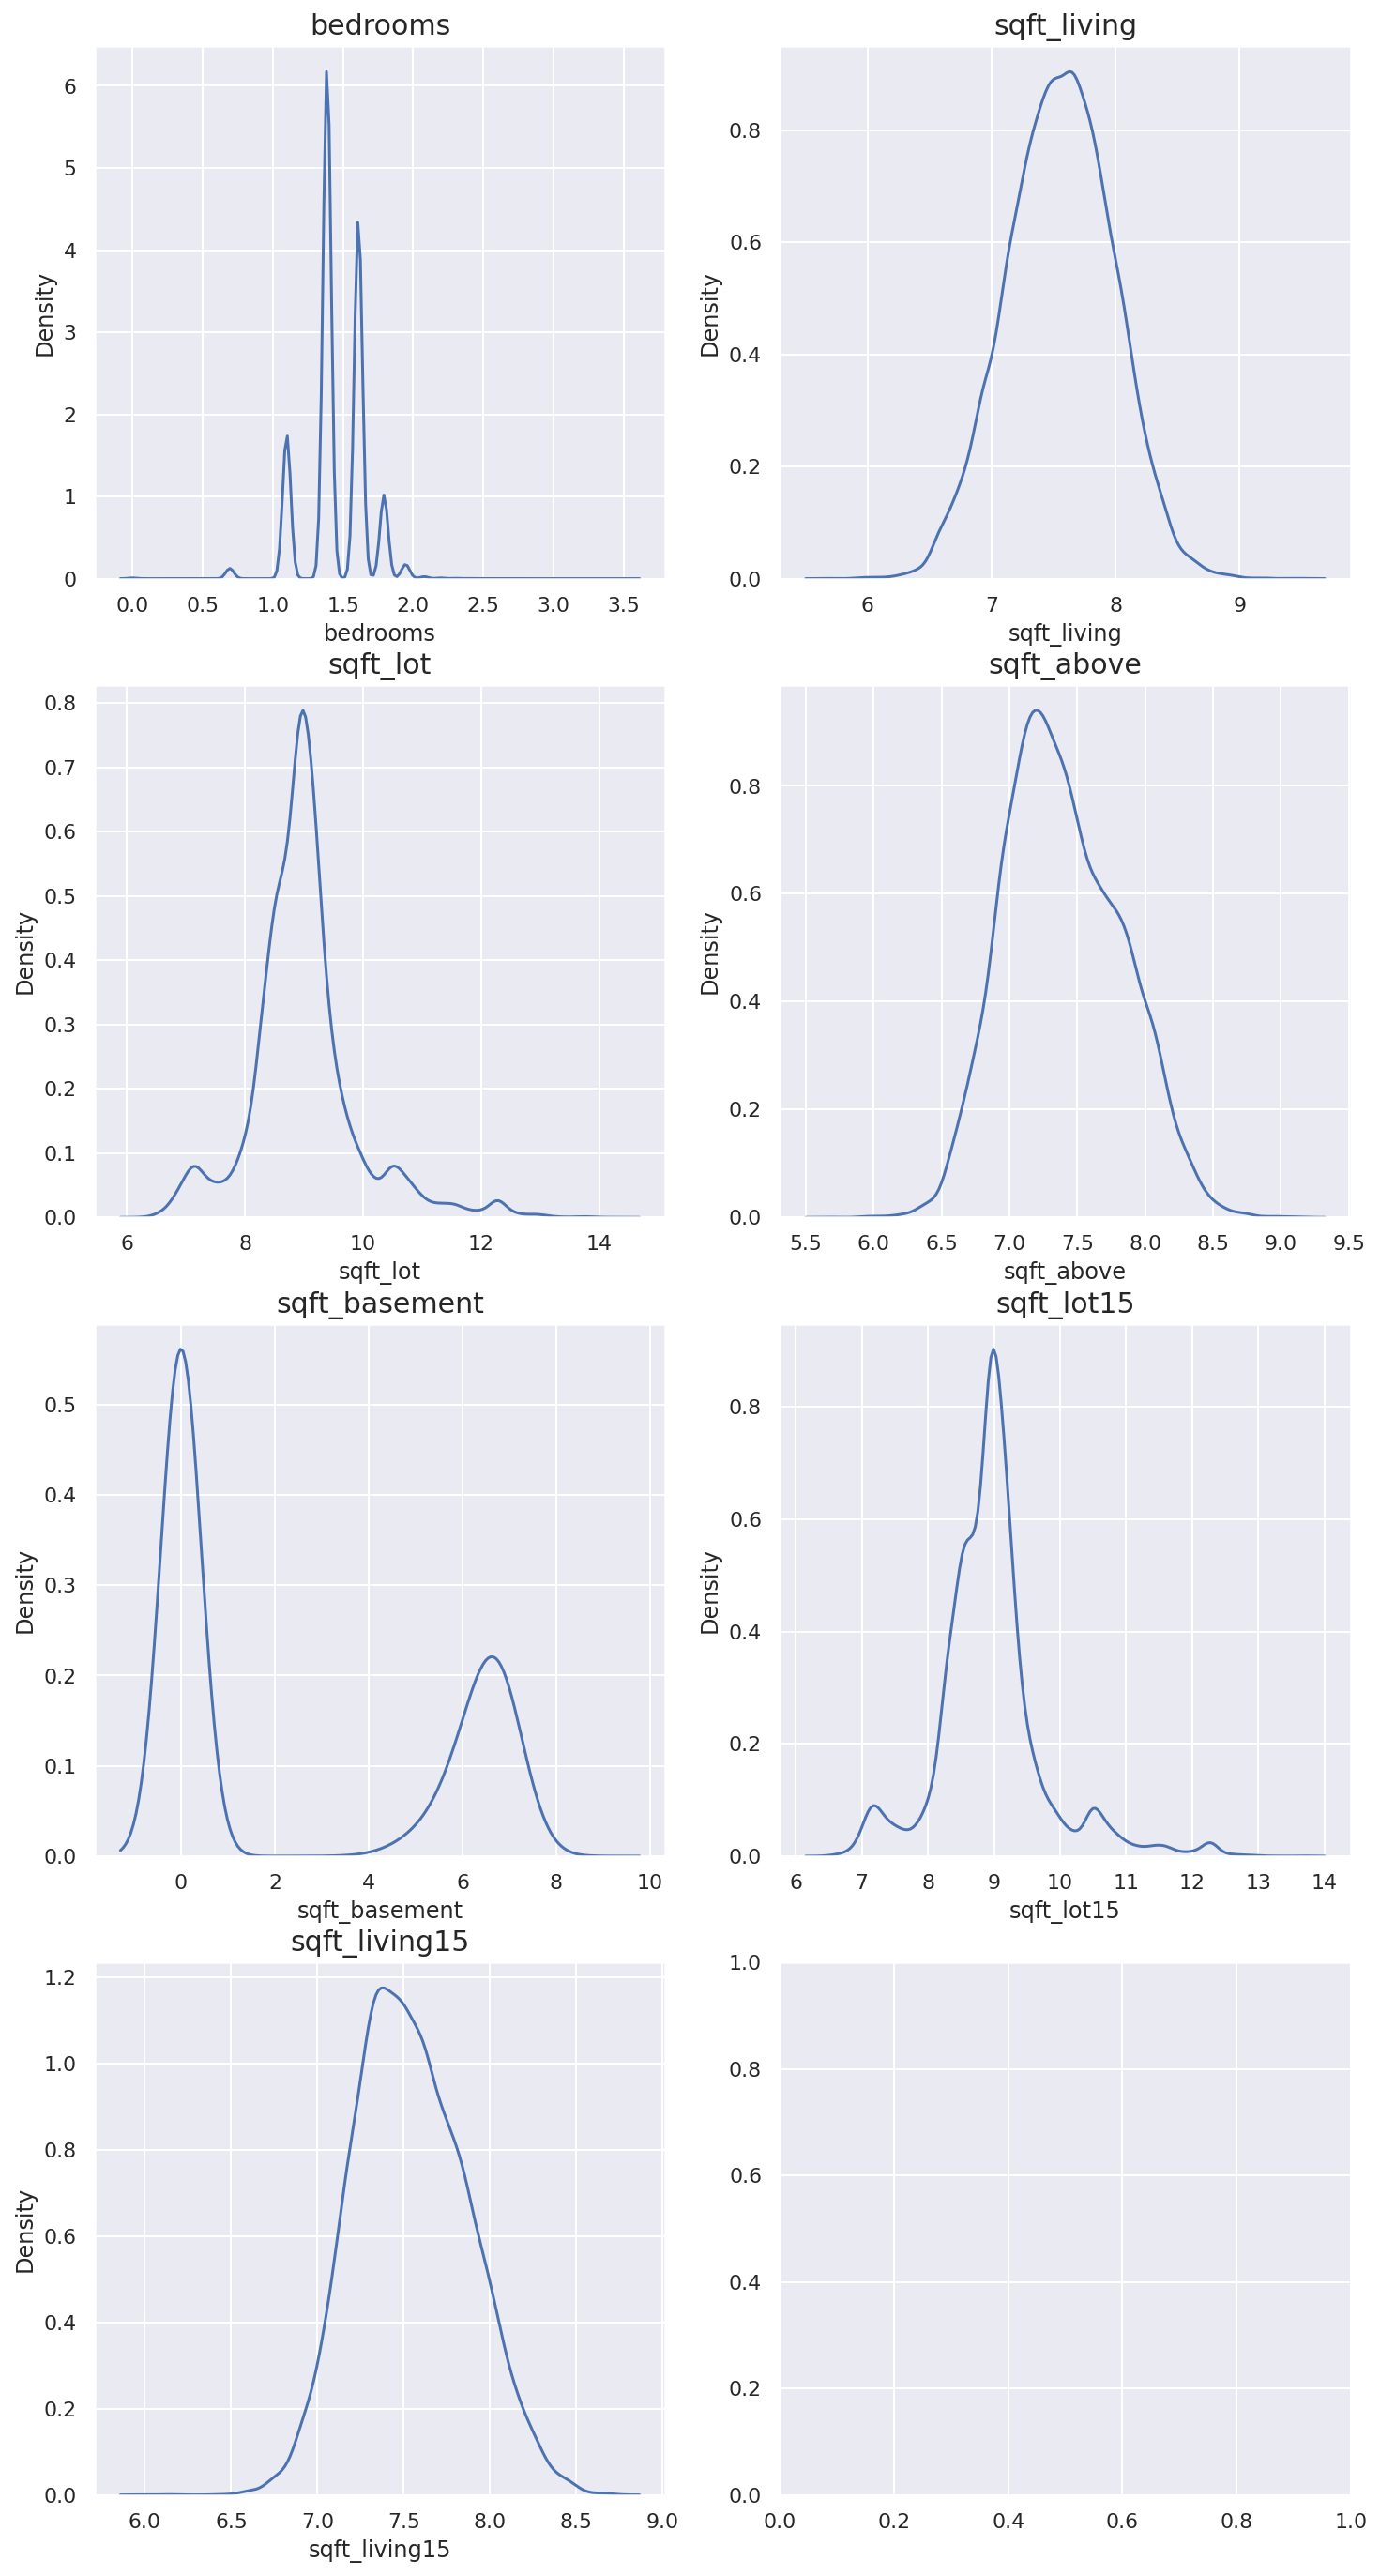

In [98]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

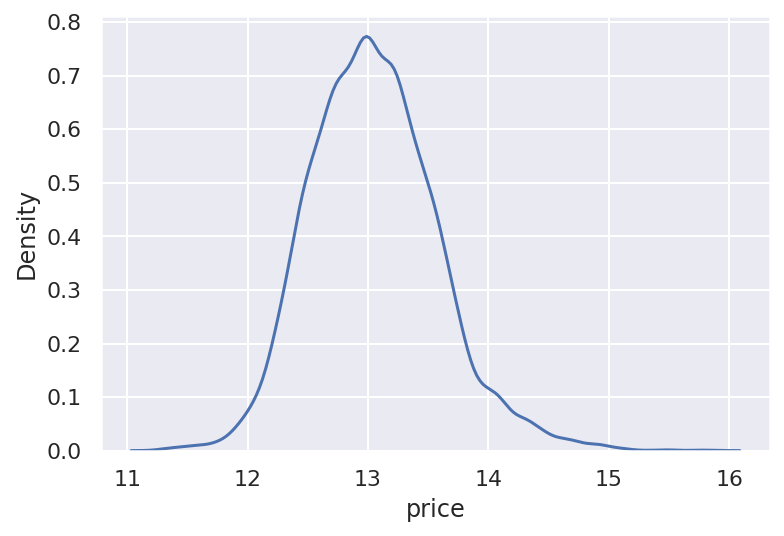

In [99]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

- 다중 공선성 문제가 있을 수 있는 데이터들을 삭제한다.
- 기준은 각 데이터들과 상관관계가 높으면서, target값과 비교적 유사성이 떨어지는 변수들을 대상으로 하였다.

In [100]:
 del data['sqft_living15']
 del data['sqft_lot15']
 del data['bedrooms']

## 모델 만들기 

In [121]:
# RMSE 계산을 위한 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [69]:
random_state=2020        

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [101]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [102]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,127799.935212
RandomForestRegressor,126356.911711
XGBRegressor,111828.396876
LGBMRegressor,111741.684999


In [103]:
# 그리드 탐색으로 하이퍼 파라미터 튜닝하는 함수 만들기

In [104]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [156]:
# 생성한 함수로 그리드 탐색
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.2s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027268,0.165131
2,10,50,-0.029297,0.171165
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [157]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)

In [105]:
# 제출을 위한 함수 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [159]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


 ### 2차 시도: XGBRegressor 적용
 - LGBM으로는 결과가 좋지 않아 XGB 모델을 적용해 보았다.

In [165]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  5.3min finished


,max_depth,n_estimators,score,RMSLE
2,10,50,-0.031911,0.178637
3,10,100,-0.032261,0.179614
1,1,100,-0.043046,0.207475
0,1,50,-0.048745,0.220782


In [166]:
model = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)

In [167]:
save_submission(model, train, y, test, 'xgbr', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgbr_RMSLE_0.0168.csv saved!


 ### 3차 시도: RandomForestRegressor 적용
  - LGBM, XGB으로는 결과가 좋지 않아 RandomForest 모델을 적용해 보았다.

In [168]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [1, 10, 15, 20],
}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   55.1s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  5.8min finished


,max_depth,n_estimators,score,RMSLE
15,20,200,-0.032045,0.179012
14,20,150,-0.032166,0.179348
11,15,200,-0.032258,0.179605
13,20,100,-0.032330,0.179806
10,15,150,-0.032372,0.179922
9,15,100,-0.032583,0.180508
12,20,50,-0.032766,0.181014
8,15,50,-0.032947,0.181514
7,10,200,-0.035149,0.187480
6,10,150,-0.035234,0.187707


In [169]:
model = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=random_state)

In [170]:
save_submission(model, train, y, test, 'rfr', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_rfr_RMSLE_0.0168.csv saved!


### 4차 시도: GradientBoostingRegressor 모델 적용
 - LGBM, XGB, RandomForest 으로는 결과가 좋지 않아 GradientBoosting 모델을 적용해 보았다.

In [177]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   48.4s
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed:  4.7min finished


,learning_rate,max_depth,n_estimators,score,RMSLE
23,0.10,5,100,-0.028647,0.169253
22,0.10,5,75,-0.029645,0.172178
17,0.05,10,100,-0.030068,0.173402
26,0.10,10,100,-0.030322,0.174133
25,0.10,10,75,-0.030342,0.174190
24,0.10,10,50,-0.030694,0.175196
16,0.05,10,75,-0.030718,0.175265
14,0.05,5,100,-0.031433,0.177294
21,0.10,5,50,-0.031501,0.177486
15,0.05,10,50,-0.033362,0.182654


In [178]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=100,  learning_rate=0.1, random_state=random_state)

In [179]:
save_submission(model, train, y, test, 'gbr', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_gbr_RMSLE_0.0168.csv saved!


## 하이퍼파라미터 튜닝
- 모델을 변경해도 점수가 나아지질 않아서 하이퍼 파라미터 튜닝을 시도했다.
- learning_rate: 부스팅 각 이터레이션 마다 곱해지는 가중치(loss function의 step size)로 모형 성능과 학습시간에 영향
- n_estimators: 부스팅 이터레이션 수로 모델 성능과 학습시간, 램 사용량에 영향을 준다.
- max_depth: 각 트리의 최대 깊이
- num_leaves: 각 트리의 최대 리프 수
- early_stopping_rounds: 조기 종료 조건
- bagging_fraction, subsample: 각 이터레이션에 사용되는 행의 비율
- min_child_weight: 관측치에 대한 가중치 합의 최소
- gamma: gain 값이 gamma 이상일 경우 자식 노드를 생성하도록 한다
- feature_fraction, colsample_bytree: 각 이터레이션에 사용되는 칼럼의 비율
- nthread: 학습에 사용할 thread수
- scale_pos_weight: posivite label에 가중치를 부여하는 것


### 5차 시도: LGBMRegressor + 하이퍼파라미터 튜닝
- 앞선 시도들 중에 그나마 LGBM 결과가 가장 좋았어서 해당 모델로 하이퍼 파라미터 튜닝을 시도했다.

In [164]:
param_grid = {
    'learning_rate': [0.001, 0.1],
    'n_estimators':[50, 100],
    'max_depth': [1, 10],
    'num_leaves': [31, 40 ,50]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  52 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed:   14.9s finished


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
22,0.100,10,100,40,-0.027107,0.164642
23,0.100,10,100,50,-0.027115,0.164665
21,0.100,10,100,31,-0.027268,0.165131
20,0.100,10,50,50,-0.028441,0.168644
19,0.100,10,50,40,-0.028837,0.169814
18,0.100,10,50,31,-0.029297,0.171165
17,0.100,1,100,50,-0.055020,0.234564
16,0.100,1,100,40,-0.055020,0.234564
15,0.100,1,100,31,-0.055020,0.234564
14,0.100,1,50,50,-0.073394,0.270914


In [171]:
model = LGBMRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, num_leaves=40, random_state=random_state)

In [172]:
save_submission(model, train, y, test, 'lgbm_2', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_2_RMSLE_0.0168.csv saved!


### 6차 시도: LGBMRegressor + 하이퍼파라미터 튜닝 2

In [190]:
param_grid = {
    'learning_rate': [0.001, 0.1],
    'n_estimators':[50, 100],
    'early_stopping_rounds': [0, 50, 100],
    'max_depth': [1, 10, 15, 20],
    'num_leaves': [20, 31, 40 ,50],
    'bagging_fraction': [0, 0.7, 1],
    'feature_fraction': [0.3, 0.7, 1]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 871 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 2495 tasks      | elapsed:   15.0s
[Parallel(n_jobs=5)]: Done 3233 tasks      | elapsed:   49.4s
[Parallel(n_jobs=5)]: Done 3598 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 4043 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 4570 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 5177 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 5866 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 6635 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 7486 tasks      | elapsed:  5.6min
[Parallel(n_jobs=5)]: Done 8417 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 8640 out of 8640 | elapsed:  6.2min finished


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=0, early_stopping_rounds=0 will be ignored. Current value: early_stopping_round=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


,bagging_fraction,early_stopping_rounds,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
767,0.7,0,1.0,0.1,20,100,50,-0.026935,0.164119
1343,1.0,0,1.0,0.1,20,100,50,-0.026935,0.164119
766,0.7,0,1.0,0.1,20,100,40,-0.027007,0.164338
1342,1.0,0,1.0,0.1,20,100,40,-0.027007,0.164338
695,0.7,0,0.7,0.1,15,100,50,-0.027040,0.164440
...,...,...,...,...,...,...,...,...,...
1723,1.0,100,1.0,0.1,20,50,50,NaN,NaN
1724,1.0,100,1.0,0.1,20,100,20,NaN,NaN
1725,1.0,100,1.0,0.1,20,100,31,NaN,NaN
1726,1.0,100,1.0,0.1,20,100,40,NaN,NaN


In [191]:
model = LGBMRegressor(
    bagging_fraction = 0.7,
    early_stopping_rounds = 0,
    feature_fraction = 1,
    max_depth=20,
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=50, 
    random_state=random_state)

In [192]:
save_submission(model, train, y, test, 'lgbm_3', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_3_RMSLE_0.0168.csv saved!


### 7차 시도: LGBMRegressor + 데이터 전처리
- 혹시 데이터 전처리를 잘못한건 아닐까 문득 생각이 들어 다시 데이터를 분석하고 모델을 학습시켰다.
- 큰 변화는 없었다.

In [33]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027268,0.165131
2,10,50,-0.029297,0.171165
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [34]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)

In [35]:
save_submission(model, train, y, test, 'lgbm_4', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_4_RMSLE_0.0168.csv saved!


### 8차 시도: LGBMRegressor + 전처리 + 하이퍼 파라미터 튜닝3

In [36]:
param_grid = {
    'learning_rate': [0.001, 0.1],
    'n_estimators':[50, 100],
    'max_depth': [1, 10],
    'num_leaves': [31, 40 ,50]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  52 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed:   14.8s finished


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
22,0.100,10,100,40,-0.027107,0.164642
23,0.100,10,100,50,-0.027115,0.164665
21,0.100,10,100,31,-0.027268,0.165131
20,0.100,10,50,50,-0.028441,0.168644
19,0.100,10,50,40,-0.028837,0.169814
18,0.100,10,50,31,-0.029297,0.171165
17,0.100,1,100,50,-0.055020,0.234564
16,0.100,1,100,40,-0.055020,0.234564
15,0.100,1,100,31,-0.055020,0.234564
14,0.100,1,50,50,-0.073394,0.270914


In [37]:
model = LGBMRegressor(max_depth=10, n_estimators=100,learning_rate=0.1,num_leaves=40 , random_state=random_state)

In [38]:
save_submission(model, train, y, test, 'lgbm_5', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_5_RMSLE_0.0168.csv saved!


### 9차 시도: LGBMRegressor + 전처리 + 하이퍼 파라미터 튜닝4

In [39]:
param_grid = {
    'learning_rate': [0.001, 0.1],
    'n_estimators':[50, 100],
    'early_stopping_rounds': [0, 50, 100],
    'max_depth': [1, 10, 15, 20],
    'num_leaves': [20, 31, 40 ,50],
    'bagging_fraction': [0, 0.7, 1],
    'feature_fraction': [0.3, 0.7, 1]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    7.2s
[Parallel(n_jobs=5)]: Done 2670 tasks      | elapsed:   15.6s
[Parallel(n_jobs=5)]: Done 3268 tasks      | elapsed:   54.3s
[Parallel(n_jobs=5)]: Done 3633 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 4078 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 4605 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 5212 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 5901 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 6670 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 7521 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 8452 tasks      | elapsed:  6.0min
[Parallel(n_jobs=5)]: Done 8640 out of 8640 | elapsed:  6.1min finished


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] early_stopping_round is set=0, early_stopping_rounds=0 will be ignored. Current value: early_stopping_round=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


,bagging_fraction,early_stopping_rounds,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
767,0.7,0,1.0,0.1,20,100,50,-0.026935,0.164119
1343,1.0,0,1.0,0.1,20,100,50,-0.026935,0.164119
766,0.7,0,1.0,0.1,20,100,40,-0.027007,0.164338
1342,1.0,0,1.0,0.1,20,100,40,-0.027007,0.164338
695,0.7,0,0.7,0.1,15,100,50,-0.027040,0.164440
...,...,...,...,...,...,...,...,...,...
1723,1.0,100,1.0,0.1,20,50,50,NaN,NaN
1724,1.0,100,1.0,0.1,20,100,20,NaN,NaN
1725,1.0,100,1.0,0.1,20,100,31,NaN,NaN
1726,1.0,100,1.0,0.1,20,100,40,NaN,NaN


In [40]:
model = LGBMRegressor(
    bagging_fraction = 0.7,
    early_stopping_rounds = 0,
    feature_fraction = 1,
    max_depth=20,
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=50, 
    random_state=random_state)

In [41]:
save_submission(model, train, y, test, 'lgbm_6', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_6_RMSLE_0.0168.csv saved!


### 10차 시도: XGBRegressor + 하이퍼 파라미터 튜닝

In [106]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    nthread=4,
    scale_pos_weight=1,
)

In [107]:
save_submission(model, train, y, test, 'xgbr_2', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgbr_2_RMSLE_0.0168.csv saved!


### 11차 시도: XGBRegressor + 하이퍼 파라미터 튜닝2

In [110]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample = 0.5,
    colsample_bytree  = 0.5,
    nthread=4,
    scale_pos_weight=1
)

In [111]:
save_submission(model, train, y, test, 'xgbr_3', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgbr_3_RMSLE_0.0168.csv saved!


### 12차 시도: XGBRegressor + 하이퍼 파라미터 튜닝3

In [116]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10, 15, 20],
    'min_child_weight': [0.5, 1, 1.5, 2],
    'gamma': [0, 0.5, 1],
    'subsample': [0, 0.5, 1],
    'colsample_bytree': [0, 0.5, 1],
    'nthread': [1, 4, 6, 10],
    'scale_pos_weight': [1]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12960 candidates, totalling 64800 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 801 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 2425 tasks      | elapsed:   13.6s
[Parallel(n_jobs=5)]: Done 4689 tasks      | elapsed:   24.0s
[Parallel(n_jobs=5)]: Done 7609 tasks      | elapsed:   37.8s
[Parallel(n_jobs=5)]: Done 11169 tasks      | elapsed:   54.4s
[Parallel(n_jobs=5)]: Done 15385 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 20241 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 22281 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 23050 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 23901 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 24832 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 25845 tasks      | elapsed:  6.7min
[Parallel(n_jobs=5)]: Done 26938 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 28113 tasks      | elap

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_threads is set with nthread=1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,nthread,scale_pos_weight,subsample,score,RMSLE
12778,1.0,1.0,0.1,15,1.5,100,10,1,0.5,-0.027129,0.164709
11296,1.0,0.5,0.1,15,1.0,100,4,1,0.5,-0.027129,0.164709
11294,1.0,0.5,0.1,15,1.0,100,1,1,1.0,-0.027129,0.164709
11293,1.0,0.5,0.1,15,1.0,100,1,1,0.5,-0.027129,0.164709
11267,1.0,0.5,0.1,15,0.5,100,10,1,1.0,-0.027129,0.164709
...,...,...,...,...,...,...,...,...,...,...,...
12945,1.0,1.0,0.1,20,2.0,75,10,1,0.0,NaN,NaN
12948,1.0,1.0,0.1,20,2.0,100,1,1,0.0,NaN,NaN
12951,1.0,1.0,0.1,20,2.0,100,4,1,0.0,NaN,NaN
12954,1.0,1.0,0.1,20,2.0,100,6,1,0.0,NaN,NaN


In [117]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=100,
    max_depth=15,
    min_child_weight=1.5,
    gamma=1,
    subsample = 0.5,
    colsample_bytree  = 1,
    nthread=10,
    scale_pos_weight=1
)

In [118]:
save_submission(model, train, y, test, 'xgbr_4', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgbr_4_RMSLE_0.0168.csv saved!


## 캐글 제출 결과
- 많은 시도들과 많은 제출을 진행했지만, 가장 110000와 근접했던건 10번째와 11번째 시도였다.
- 아쉽게도 110310정도로 마무리를 해야했다.
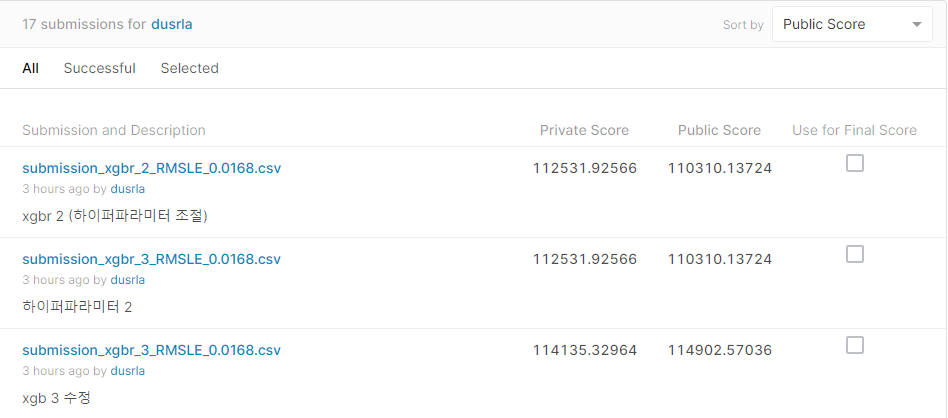

## 회고

지금까지 아이펠에서 프로젝트를 그리 많이 해오지는 않았지만,, 내가 부족한 자임을 깨닫게 해주는 최고의 프로젝트였다.

데이터 분석부터 데이터 전처리, 그리고 하이퍼파라미터 튜닝까지,, 무엇하나 공부하지 않으면 손댈 수 없었다.

그리고 공부한다고 해서 바로 적용하기도 어려운 것들이 많았다.

데이터를 분석한다고 열심히 해보았지만, 확실하기 부족하고 엉성한 부분이 많은 것 같다.

기본이 없어서 급하게 학습을 해서 하려하다보니 그랬던 것 같다.

긴 글로 작성을 했지만 결론적으로는 아직 부족한 부분이 많으니 여러 부분에서 많은 공부가 필요할 것 같는 말이다.

특히나 데이터 전처리를 공부하는 것에 대한 갈증이 대단하다..

전처리... 정말 잘하고 싶다 ..!!!!!

공부를 더 해야겠다. 

아쉬움과 부족함이 많은 프로젝트 였지만, 이 역시도 다음을 위해 좋은 거름이 될 것이라 생각하고,,, 이만 더 공부하러 가야겠다.


---

## 참고 링크

[XGBoost와 LightGBM 하이퍼파라미터 튜닝 가이드](https://psystat.tistory.com/131)

[XGBoost (2) - Parameter 이해와 현업자의 설정 방법](https://dining-developer.tistory.com/4)

[[ML] XGBoost 개념 이해](https://wooono.tistory.com/97)

[Light GBM(LGBM)의 개요와 파라미터 정의에 대해](https://nicola-ml.tistory.com/51)